# FiapDataAnaliticsD7-Datathon

O projeto desta etapa envolve a criação de um sistema de recomendação, que analisa pré-requisitos de vagas de emprego e analisa perfils de candidatos utilizando inteligencia artificial, para definir o melhor "match" entre vaga vs candidato. 

A base disponibilidade pelo desafio é composta de informações como:
* Perfil dos aplicantes = Um dicionário de informações contendo informações pré extruturadas e de texto bruto (raw).
* Caracteristica das Vagas = Um dicionário de informações sobre os pré-requisitos das vagas. 
* Lista de aplicantes = Um dicionário com informações dos aplicantes em cada vaga com detalhes de selecionados e alinhamentos iniciais sobre a vaga.

O critério para a recomendação da vaga deve levar em conta fatores como habilidades, conhecimentos e similaridades culturais compartilhas entre empresa e funcionário.

**Integrantes:**
* Marlon Fernandez - RM353490
* Roberto Muller - RM353491

Link para dashboard: [Dashboard](https://datathon-fiap-grupo13.streamlit.app/)

## 1. Introdução e objetivo trabalho

### 1.1 Imports

In [1]:
# pip install langdetect googletrans==4.0.0rc1
# pip install transformers sentencepiece torch
# pip install tqdm
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_recall_curve, f1_score
from tqdm import tqdm
import joblib
import pickle
import re
from transformers import MarianMTModel, MarianTokenizer
import langid
from collections import Counter


import warnings
warnings.filterwarnings("ignore")

### 1.2 Extruturação dos dados 

Durante a processo de deploy da base no ambiente do Streamlit foram identificados problemas de performance e execução com a base de dados treinamento, quando carregados a base completa de aplicantes.

Analisando as soluções disponívels, a equipe optou por utilizar um subset dos dados no ambiente de produção que resolveu o problema de performance e não prejudicou a acuracia do modelo, porém em um cenário de utilização real o ideal seria executar o dashboard localmente.

Abaixo temos a chave para alterar o carregamento dos dados para utilizar dados em arquivo local ou em núvem.

#### 1.2.1 Definido fonta dos dados

Na variável $MODO_LOCAL é definido a origem dos arquivos a serem utilizados para rodar o código
* 1 irá utilizar arquivos grandes e processamento local
* 0 irá utilizar amostras para processamento em cloud/MVP DEMO

In [2]:
MODO_LOCAL = 0
# 1 Local
# 0 Cloud/MVP DEMO

#### 1.2.2 Gerando samples de canditados

As funções abaixo carregam a base de dados dos candidatos(aplicantes) e das vagas, limpando de definido vagas e candidatos válidos para montar a base de dados com 5.000 linhas.

In [3]:
def entrada_valida(candidato):
    if not isinstance(candidato, dict):
        return False
    cv = candidato.get('cv_pt', '')
    nome = candidato.get('infos_basicas', {}).get('nome', '')
    return bool(cv and cv.strip()) and bool(nome and nome.strip())

with open('applicants.json', encoding='utf-8') as f:
    data = json.load(f)

validos = {k: v for k, v in data.items() if entrada_valida(v)}
amostra = dict(list(validos.items())[:5000])

with open('applicants_sample.json', 'w', encoding='utf-8') as f:
    json.dump(amostra, f, ensure_ascii=False, indent=2)

def vaga_valida(vaga):
    titulo = vaga.get('informacoes_basicas', {}).get('titulo_vaga', '')
    perfil = vaga.get('perfil_vaga', {})
    return bool(titulo and titulo.strip()) and bool(perfil)

with open('vagas.json', encoding='utf-8') as f:
    data = json.load(f)

validos = {k: v for k, v in data.items() if vaga_valida(v)}
amostra = dict(list(validos.items())[:5000])
with open('vagas_sample.json', 'w', encoding='utf-8') as f:
    json.dump(amostra, f, ensure_ascii=False, indent=2)

#### 1.2.3 Carregando base

Vamos agora ler os arquivos disponibilizados para começar a explorar os dados e entender sua estrutura:

In [4]:
if MODO_LOCAL:
    path_applicants = 'applicants.json'
    path_prospects = 'prospects.json'
    path_vagas = 'vagas.json'
else:
    path_applicants = 'applicants_sample.json'
    path_prospects = 'prospects.json'
    path_vagas = 'vagas.json' # usar vagas_sample.json apenas se houver problemas de performanca

print(f'Carregando base de candidatos de {path_applicants}')

with open(path_applicants, 'r', encoding='utf-8') as f:
    applicants_data = json.load(f)

with open(path_prospects, 'r', encoding='utf-8') as f:
    prospects_data = json.load(f)

with open(path_vagas, 'r', encoding='utf-8') as f:
    vagas_data = json.load(f)

print("Applicants - quantidade de candidatos:", len(applicants_data))
print("Prospects - quantidade de vagas:", len(prospects_data))
print("Vagas - quantidade de vagas:", len(vagas_data))


Carregando base de candidatos de applicants_sample.json
Applicants - quantidade de candidatos: 5000
Prospects - quantidade de vagas: 14222
Vagas - quantidade de vagas: 14081


Concluímos a leitura do arquivos e identificamos a quantidade de informaçoes carregadas em cada variáveis.

Iremos visualizar amostras dos conteúdos gerados

In [5]:
# Visualizando amostra de candidatos
print("\n--- Exemplo de candidato em applicants ---")
for i, (k, v) in enumerate(applicants_data.items()):
    print(f"ID {k}: {list(v.keys())}")
    if i == 2: break

# Visualizando amostra de candidatos em prospects
print("\n--- Exemplo de vaga em prospects ---")
for i, (k, v) in enumerate(prospects_data.items()):
    print(f"Vaga {k}: {v['titulo']}, {len(v['prospects'])} candidatos")
    if v['prospects']:
        print("  1º prospect:", v['prospects'][0])
    if i == 2: break

# Visualizando amostra de vagas
print("\n--- Exemplo de vaga em vagas ---")
for i, (k, v) in enumerate(vagas_data.items()):
    print(f"Vaga {k}: {v['informacoes_basicas'].get('titulo_vaga')}")
    print("  Perfil:", v['perfil_vaga'].get('principais_atividades', '')[:200], "...")
    if i == 2: break



--- Exemplo de candidato em applicants ---
ID 31000: ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en']
ID 31001: ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en']
ID 31002: ['infos_basicas', 'informacoes_pessoais', 'informacoes_profissionais', 'formacao_e_idiomas', 'cargo_atual', 'cv_pt', 'cv_en']

--- Exemplo de vaga em prospects ---
Vaga 4530: CONSULTOR CONTROL M, 2 candidatos
  1º prospect: {'nome': 'José Vieira', 'codigo': '25632', 'situacao_candidado': 'Encaminhado ao Requisitante', 'data_candidatura': '25-03-2021', 'ultima_atualizacao': '25-03-2021', 'comentario': 'Encaminhado para  - PJ R$ 72,00/hora', 'recrutador': 'Ana Lívia Moreira'}
Vaga 4531: 2021-2607395-PeopleSoft Application Engine-Domain Consultant, 2 candidatos
  1º prospect: {'nome': 'Sra. Yasmin Fernandes', 'codigo': '25364', 'situacao_candidado': 'Contratado pela De

In [6]:
# Checando correspondência entre prospects e applicants
print("\n--- Checando correspondência entre prospects e applicants ---")
matches = 0
checked = 0
for vaga_id, vaga in prospects_data.items():
    for p in vaga['prospects']:
        if p['codigo'] in applicants_data:
            matches += 1
        checked += 1
    if checked > 100: break
print(f"De {checked} prospects analisados, {matches} estão presentes no applicants.json.")

situacoes = []
for vaga in prospects_data.values():
    for p in vaga['prospects']:
        situacoes.append(p.get('situacao_candidado'))
print("\nDistribuição das situações dos candidatos (top 10):")
print(Counter(situacoes).most_common(10))


--- Checando correspondência entre prospects e applicants ---
De 101 prospects analisados, 9 estão presentes no applicants.json.

Distribuição das situações dos candidatos (top 10):
[('Prospect', 20021), ('Encaminhado ao Requisitante', 16122), ('Inscrito', 3980), ('Não Aprovado pelo Cliente', 3492), ('Contratado pela Decision', 2758), ('Desistiu', 2349), ('Não Aprovado pelo RH', 1765), ('Não Aprovado pelo Requisitante', 765), ('Entrevista Técnica', 579), ('Sem interesse nesta vaga', 576)]


Após confirmarmos que as informações dos aplicantes estão presents na lista de canditados prospectados e que possuimos informações para embassar a dicisão de contratação/avanço no processo seletivo, podemos seguir nos aprofundar na análise e definir target para o nosso modelo de Machine Learning.

## 2. Extruturação dos dados 

#### 2.1 Determinando variável Target

Entendendo um pouco melhor nossa base de dados, vamos agora delimitar a forma com podemos identificar o candidato selecionado para a vaga.

Definimos que os candidatos prospectados com situação '*Contratado pela Decision*', '*Contratado como Hunting*' e *'Aprovado'* foram candidatos com perfil aprovado no processo inicial de entrevista, logo iremos defini-los como perfil "Target" para o processo de treinamento.

In [7]:
labels_sucesso = {'Contratado pela Decision', 'Contratado como Hunting', 'Aprovado'}

rows = []
for vaga_id, vaga in prospects_data.items():
    for p in vaga['prospects']:
        row = {
            'vaga_id': vaga_id,
            'candidato_id': p['codigo'],
            'nome_candidato': p['nome'],
            'situacao_candidado': p.get('situacao_candidado', None),
            'comentario': p.get('comentario', None),
            'recrutador': p.get('recrutador', None),
            'data_candidatura': p.get('data_candidatura', None),
            'ultima_atualizacao': p.get('ultima_atualizacao', None)
        }

        row['target'] = int(p.get('situacao_candidado', '') in labels_sucesso)
        rows.append(row)

df = pd.DataFrame(rows)

#### 2.1 Resultado da variavel Target

In [8]:
print("Shape do dataframe de pares vaga-candidato:", df.shape)
print("\nProporção de classes (target=1 é sucesso):")
print(df['target'].value_counts(normalize=True))
print("\n5 primeiras linhas:")
print(df.head())

Shape do dataframe de pares vaga-candidato: (53759, 9)

Proporção de classes (target=1 é sucesso):
target
0    0.940605
1    0.059395
Name: proportion, dtype: float64

5 primeiras linhas:
  vaga_id candidato_id            nome_candidato           situacao_candidado  \
0    4530        25632               José Vieira  Encaminhado ao Requisitante   
1    4530        25529  Srta. Isabela Cavalcante  Encaminhado ao Requisitante   
2    4531        25364     Sra. Yasmin Fernandes     Contratado pela Decision   
3    4531        25360            Alexia Barbosa  Encaminhado ao Requisitante   
4    4533        26338            Arthur Almeida     Contratado pela Decision   

                                          comentario         recrutador  \
0               Encaminhado para  - PJ R$ 72,00/hora  Ana Lívia Moreira   
1  encaminhado para  - R$ 6.000,00 – CLT Full , n...  Ana Lívia Moreira   
2                         Data de Inicio: 12/04/2021   Juliana Cassiano   
3                        

Considerando que temos apenas 6% das entradas com o target=1 para trabalharmos, precisaremos balancear isto de alguma forma posteriormente.

In [9]:
print("\nCandidatos por vaga (top 5):")
print(df['vaga_id'].value_counts().head())

print("\nVagas por candidato (top 5):")
print(df['candidato_id'].value_counts().head())

print("\nExemplo de registros positivos (target=1):")
print(df[df['target'] == 1].head())



Candidatos por vaga (top 5):
vaga_id
10898    25
9898     25
7645     25
11554    25
7644     25
Name: count, dtype: int64

Vagas por candidato (top 5):
candidato_id
833      73
1677     70
12450    54
27660    53
16747    45
Name: count, dtype: int64

Exemplo de registros positivos (target=1):
   vaga_id candidato_id         nome_candidato        situacao_candidado  \
2     4531        25364  Sra. Yasmin Fernandes  Contratado pela Decision   
4     4533        26338         Arthur Almeida  Contratado pela Decision   
16    4535        26338         Arthur Almeida                  Aprovado   
22    4535        22977            Lunna Alves  Contratado pela Decision   
38    4544        19972     Sr. Miguel Sampaio  Contratado pela Decision   

                        comentario         recrutador data_candidatura  \
2       Data de Inicio: 12/04/2021   Juliana Cassiano       17-03-2021   
4                                       Stella Vieira       29-04-2021   
16  Aprovado para inicio

O máximo de candidatos por vagas que identificamos é de 25, o que pode sugerir um valor máximo de candidatos por vaga dentro do processo atual da Decision.

Outro fato que chamou atenção é que na base de dados temos candidatos se aplicando para múltiplas vagas, alguns com mais de 70 tentativas. 

### 2.2 Criação do dataframe estruturado

Iremos estruturar o Dataframe para treinar o futuro modelo de Machine learning organizando extraindo as informações chaves dos candidatos criando features.

O propósito é padronizar a representação de uma vaga. Ao ter tanto os candidatos quanto as vagas representados por dicionários "planos" com características bem definidas, conseguiremos criar um "match"de atributos.

Criaremos funções para cada banco definindo informaçöes de candidatos e vagas levando em consideração informações:
* Informação Básicas(pessoal)
* Informações Profissionais
* Formação e idiomas

O CV do canditado carregas muitas informaçoes em blocos de texto que poodem ser importantes, além de ter informações em Inglês e Portugues.


#### 2.2.1 Criando DataFrame para de candidatos 

In [10]:
def extract_applicant_features(applicant):
    f = {}
    # Infos básicas
    infos_basicas = applicant.get('infos_basicas', {})
    f['sexo'] = infos_basicas.get('sexo')
    f['idade'] = infos_basicas.get('idade')
    f['estado_civil'] = infos_basicas.get('estado_civil')
    
    # Informações profissionais
    info_prof = applicant.get('informacoes_profissionais', {})
    f['area_atuacao'] = info_prof.get('area_atuacao')
    f['nivel_profissional'] = info_prof.get('nivel_profissional')
    f['tempo_experiencia'] = info_prof.get('tempo_experiencia')
    f['ultimo_salario'] = info_prof.get('ultimo_salario')
    
    # Formação e idiomas
    formacao = applicant.get('formacao_e_idiomas', {})
    f['nivel_academico'] = formacao.get('nivel_academico')
    f['nivel_ingles'] = formacao.get('nivel_ingles')
    f['nivel_espanhol'] = formacao.get('nivel_espanhol')
    
    # Cargo atual
    f['cargo_atual'] = applicant.get('cargo_atual')
    
    # CVs
    f['cv_pt'] = applicant.get('cv_pt', '')
    f['cv_en'] = applicant.get('cv_en', '')
    return f

#### 2.2.2 Criando Dataframe para as vagas

In [11]:
def extract_vaga_features(vaga):
    f = {}
    infos_basicas = vaga.get('informacoes_basicas', {})
    perfil = vaga.get('perfil_vaga', {})
    f['titulo_vaga'] = infos_basicas.get('titulo_vaga')
    f['cliente'] = infos_basicas.get('cliente')
    f['tipo_contratacao'] = infos_basicas.get('tipo_contratacao')
    f['nivel_profissional_vaga'] = perfil.get('nivel profissional')
    f['nivel_academico_vaga'] = perfil.get('nivel_academico')
    f['nivel_ingles_vaga'] = perfil.get('nivel_ingles')
    f['nivel_espanhol_vaga'] = perfil.get('nivel_espanhol')
    f['areas_atuacao_vaga'] = perfil.get('areas_atuacao')
    f['principais_atividades_vaga'] = perfil.get('principais_atividades', '')
    return f

#### 2.2.3 Unificando os dados dos candidatos e vagas

In [12]:
def enrich_with_applicant(row):
    cand_id = row['candidato_id']
    applicant = applicants_data.get(cand_id)
    if applicant:
        feats = extract_applicant_features(applicant)
        for k, v in feats.items():
            row[f'cand_{k}'] = v
    else:
        for k in ['sexo', 'idade', 'estado_civil', 'area_atuacao', 'nivel_profissional', 
                  'tempo_experiencia', 'ultimo_salario', 'nivel_academico', 'nivel_ingles', 
                  'nivel_espanhol', 'cargo_atual', 'cv_pt', 'cv_en']:
            row[f'cand_{k}'] = np.nan
    return row

In [13]:
def enrich_with_vaga(row):
    vaga_id = row['vaga_id']
    vaga = vagas_data.get(vaga_id)
    if vaga:
        feats = extract_vaga_features(vaga)
        for k, v in feats.items():
            row[f'vaga_{k}'] = v
    else:
        for k in ['titulo_vaga', 'cliente', 'tipo_contratacao', 'nivel_profissional_vaga', 
                  'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 
                  'areas_atuacao_vaga', 'principais_atividades_vaga']:
            row[f'vaga_{k}'] = np.nan
    return row

Aplicar as funções que criamos para enriquecimento do df

In [14]:
df = df.apply(enrich_with_applicant, axis=1)
df = df.apply(enrich_with_vaga, axis=1)
# célula demora 3min+-

#### 2.3 Dataframe final

In [15]:
print("DataFrame enriquecido shape:", df.shape)
print("\nColunas disponíveis:", list(df.columns))
print("\nExemplo de linha:")
print(df.iloc[0][['candidato_id', 'cand_nivel_academico', 'cand_area_atuacao', 'cand_cv_pt', 
                  'vaga_titulo_vaga', 'vaga_nivel_profissional_vaga', 'vaga_principais_atividades_vaga']])


DataFrame enriquecido shape: (53759, 31)

Colunas disponíveis: ['vaga_id', 'candidato_id', 'nome_candidato', 'situacao_candidado', 'comentario', 'recrutador', 'data_candidatura', 'ultima_atualizacao', 'target', 'cand_sexo', 'cand_idade', 'cand_estado_civil', 'cand_area_atuacao', 'cand_nivel_profissional', 'cand_tempo_experiencia', 'cand_ultimo_salario', 'cand_nivel_academico', 'cand_nivel_ingles', 'cand_nivel_espanhol', 'cand_cargo_atual', 'cand_cv_pt', 'cand_cv_en', 'vaga_titulo_vaga', 'vaga_cliente', 'vaga_tipo_contratacao', 'vaga_nivel_profissional_vaga', 'vaga_nivel_academico_vaga', 'vaga_nivel_ingles_vaga', 'vaga_nivel_espanhol_vaga', 'vaga_areas_atuacao_vaga', 'vaga_principais_atividades_vaga']

Exemplo de linha:
candidato_id                                                                   25632
cand_nivel_academico                                                             NaN
cand_area_atuacao                                                                NaN
cand_cv_pt      

## 3. Análise Exploratória de Dados

Com nosso dataframe criado, podemos explorar e extrair insights iniciais sobre as informações das vagas e candidatos.

### 3.1 Feature Check e amostra de dados

In [16]:
features_to_check = [
    'cand_nivel_academico', 'cand_area_atuacao', 'cand_nivel_ingles', 'cand_nivel_espanhol',
    'vaga_nivel_profissional_vaga', 'vaga_nivel_academico_vaga', 'vaga_nivel_ingles_vaga',
    'vaga_areas_atuacao_vaga', 'vaga_principais_atividades_vaga'
]
print("Percentual de preenchimento:")
for col in features_to_check:
    percent = df[col].notnull().mean() * 100
    print(f"{col}: {percent:.1f}%")

Percentual de preenchimento:
cand_nivel_academico: 14.0%
cand_area_atuacao: 14.0%
cand_nivel_ingles: 14.0%
cand_nivel_espanhol: 14.0%
vaga_nivel_profissional_vaga: 100.0%
vaga_nivel_academico_vaga: 100.0%
vaga_nivel_ingles_vaga: 100.0%
vaga_areas_atuacao_vaga: 100.0%
vaga_principais_atividades_vaga: 100.0%


Os campos relacionados às vagas estarem 100% preenchidos indica que são ótimos para considerarmos como features.

In [17]:
print("\nPrincipais valores (top 5) de cada coluna categórica:\n")
for col in ['cand_nivel_academico', 'cand_area_atuacao', 'cand_nivel_ingles', 'vaga_nivel_profissional_vaga']:
    print("\n")
    print(df[col].value_counts().head())


Principais valores (top 5) de cada coluna categórica:



cand_nivel_academico
                              5421
Ensino Superior Completo       994
Pós Graduação Completo         481
Ensino Superior Cursando       234
Ensino Superior Incompleto     113
Name: count, dtype: int64


cand_area_atuacao
                                    5481
TI - SAP                             383
TI - Desenvolvimento/Programação     381
Administrativa                       126
TI - Projetos                         92
Name: count, dtype: int64


cand_nivel_ingles
                 5436
Intermediário     740
Básico            580
Avançado          525
Fluente           183
Name: count, dtype: int64


vaga_nivel_profissional_vaga
Sênior          20978
Analista        17887
Pleno            9852
Júnior           1984
Especialista     1124
Name: count, dtype: int64


Temos um número considerável de entradas em branco, vamos tratar esses dados para evitar erros posteriormente

In [18]:
df['len_cv'] = df['cand_cv_pt'].fillna('').apply(len)
df['len_desc_vaga'] = df['vaga_principais_atividades_vaga'].fillna('').apply(len)
print("\nTamanho médio do CV (pt):", df['len_cv'].mean())
print("Tamanho médio da descrição da vaga:", df['len_desc_vaga'].mean())

print("\nAmostra de CV do candidato:")
print(df['cand_cv_pt'].dropna().iloc[0][:300])

print("\nAmostra de descrição da vaga:")
print(df['vaga_principais_atividades_vaga'].dropna().iloc[0][:300])



Tamanho médio do CV (pt): 680.9314347365092
Tamanho médio da descrição da vaga: 438.5958816198218

Amostra de CV do candidato:
solteiro, brasileiro, 21/06/1987
habilitação categoria “ab”
objetivo

atuar em times ágeis, conseguir levar os valores que acredito serem essenciais em termos de qualidade em projetos de software e provar o quanto isso é benéfico para o processo de desenvolvimento de um produto.
ajudar um time a cui

Amostra de descrição da vaga:
- Experiência comprovada em projetos de control-M


### 3.2 Filtrando campos em branco 

Função para definir como "Desconhecido" se tivermos valores faltantes

In [19]:
def clean_cat(col, default='Desconhecido'):
    return df[col].replace('', default).fillna(default)

In [20]:
for col in ['cand_nivel_academico', 'cand_area_atuacao', 'cand_nivel_ingles', 'cand_nivel_espanhol']:
    df[col] = clean_cat(col)

In [21]:
df['text_candidato'] = df['cand_cv_pt'].fillna('')
df['text_vaga'] = df['vaga_principais_atividades_vaga'].fillna('')

print("\nExemplo de texto candidato:\n", df['text_candidato'].iloc[0][:500])
print("\nExemplo de texto vaga:\n", df['text_vaga'].iloc[0][:300])


Exemplo de texto candidato:
 

Exemplo de texto vaga:
 - Experiência comprovada em projetos de control-M


## 4. Embeddings



Durante a análise dos currículos (CVs), identificamos uma grande variedade de termos técnicos, além de uma mistura de expressões em português e inglês, e textos descritivos sobre os candidatos.

Para garantir maior eficiência e padronização no processamento dos dados, optamos por traduzir todo o conteúdo dos CVs para o português utilizando um modelo de IA pré-treinado da Hugging Face antes de realizar o embedding dos textos.

**Observação:**  
Devido a limitações de processamento local e em nuvem, iremos apenas demonstrar a quantidade de CVs que possuem conteúdo majoritariamente em inglês. O treinamento do modelo será realizado exclusivamente com textos em português (pt-BR).

### 4.1 Funçao de normalização de texto



#### 1. `traduzir_en_para_pt()`: Traduzir Texto
Esta função utiliza um modelo pré-carregado para traduzir textos do inglês para o português.

---

#### 2. `extrair_narrativa_cv()`: Extrair Resumo do CV 📄
Isola a primeira parte de um CV, buscando palavras-chave para extrair habilidades dos candidatos.

---

#### 3. `extrair_skills_vaga()`: Extrair Competências da Vaga 🎯
Escaneia o texto de uma descrição de vaga para identificar e listar as competências técnicas exigidas.

- **Detecta palavras com duas ou mais letras maiúsculas** (comum para siglas como SQL, AWS, BI).
- **Busca em uma lista pré-definida de tecnologias comuns** (Java, Python, Azure, etc).

---

#### 4. `score_matching_skills()`: Calcular Pontuação de Compatibilidade 💯
Calcula uma pontuação de 0 a 1 que representa o quão bem as competências de um candidato correspondem às competências exigidas pela vaga.

In [22]:
#Define o modelo de tradução
model_name = 'Helsinki-NLP/opus-mt-tc-big-en-pt'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Função para traduzir texto de inglês para português
def traduzir_en_para_pt(texto):
    if not texto or len(texto.strip()) == 0:
        return texto
    batch = tokenizer([texto], return_tensors="pt", truncation=True, padding=True)
    gen = model.generate(**batch)
    traduzido = tokenizer.batch_decode(gen, skip_special_tokens=True)[0]
    return traduzido

# Função para normalizar skills e experiência dos candidatos   
def extrair_narrativa_cv(cv_texto):
    match = re.split(r'(experiência|experience|skills|habilidades|certificados)', cv_texto, flags=re.IGNORECASE)
    return match[0] if match else cv_texto[:1000] # 1000 caracteres

# Extrai todas as palavras maiúsculas e siglas, além de algumas comuns em tech
def extrair_skills_vaga(texto_vaga):
    padrao = r'\b[A-Z]{2,}\b|\b(?:Java|Python|SQL|Azure|AWS|SAP|Excel|Linux|Agile|Node|React|C#|C\+\+|Oracle|BI|PowerBI|RPA|DevOps)\b'
    return set(re.findall(padrao, texto_vaga, flags=re.IGNORECASE))


def score_matching_skills(cv_texto, skills_vaga):
    skills_cv = set([x.lower() for x in re.findall(r'\b\w+\b', cv_texto)])
    skills_vaga = set([x.lower() for x in skills_vaga])
    if not skills_vaga:
        return 0
    return len(skills_cv & skills_vaga) / len(skills_vaga)

### 4.2 Detecção e tradução de idioma/texto

#### 4.2.1 Funçao Langid
Esta função, detect_langid, serve para identificar o idioma de um texto usando a biblioteca langid.

In [23]:
def detect_langid(text, default='pt'):
    if not isinstance(text, str) or not text.strip() or not re.search(r'[a-zA-Z]', text):
        return default
    lang, _ = langid.classify(text)
    return lang

----

#### 4.2.2 Traduçao de conteúdo

Essa parte aqui na linha que tá comentada, vai tentar traduzir os CV em ingles... meu note demorou muito muito. Pra rodar, só troca e põe o # na próxima linha

In [25]:
textos_cv_processados = []
textos_vaga_processados = []
scores_skills = []
qnt_en = 0
qnt_pt = 0

for i, row in tqdm(df.iterrows(), total=len(df)):
    cv_texto = row['text_candidato']
    vaga_texto = row['text_vaga']
    lang_cv = detect_langid(cv_texto)
    if lang_cv == 'en': 
        qnt_en = qnt_en+1 
    else: 
        qnt_pt = qnt_pt+1
    #cv_traduzido = traduzir_en_para_pt(cv_texto) if lang_cv == 'en' else cv_texto
    cv_traduzido = cv_texto
    narrativa_cv = extrair_narrativa_cv(cv_traduzido)
    skills_vaga = extrair_skills_vaga(vaga_texto)
    score_skills = score_matching_skills(cv_traduzido, skills_vaga)
    textos_cv_processados.append(narrativa_cv)
    textos_vaga_processados.append(vaga_texto)
    scores_skills.append(score_skills)
print(f'CVs em Português: {qnt_pt}')
print(f'CVs em Inglês: {qnt_en}')

100%|██████████| 53759/53759 [00:57<00:00, 942.70it/s] 

CVs em Português: 53284
CVs em Inglês: 475


### 4.3 Criação de Embeddings e Calculo de similaridade do Cosseno



### 4.3 Criação de Embeddings e Cálculo de Similaridade



Nesta etapa, o texto dos candidatos (já traduzido para português) será transformado em vetores numéricos (embeddings) utilizando a biblioteca **Sentence Transformer**, especificamente o modelo `paraphrase-multilingual-MiniLM-L12-v2`.

Após a geração dos embeddings, será realizada a comparação entre os vetores dos candidatos e das vagas por meio da **similaridade do cosseno**. Esse cálculo permite determinar o grau de compatibilidade entre o perfil do candidato e os requisitos da vaga.

- **Ferramenta utilizada:** Sentence Transformer  
- **Modelo:** paraphrase-multilingual-MiniLM-L12-v2  
- **Métrica de comparação:** Similaridade do cosseno entre os embeddings de candidato e vaga

In [26]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

emb_candidato = model.encode(textos_cv_processados, show_progress_bar=True)
emb_vaga = model.encode(textos_vaga_processados, show_progress_bar=True)

similaridades = [cosine_similarity([emb_candidato[i]], [emb_vaga[i]])[0][0] for i in range(len(textos_cv_processados))]

df['similaridade_cv_vaga'] = similaridades
df['score_matching_skills'] = scores_skills

print("Preview de similaridades e matching de skills:")
print(df[['candidato_id', 'vaga_id', 'similaridade_cv_vaga', 'score_matching_skills', 'target']].head(10))

#df.to_csv('df_com_embeddings_e_skills.csv', index=False)
print("\nSubset salvo com embeddings, similaridade e score de matching de skills.")
#23min+-

Batches:   0%|          | 0/1680 [00:00<?, ?it/s]

Batches:   0%|          | 0/1680 [00:00<?, ?it/s]

Preview de similaridades e matching de skills:
  candidato_id vaga_id  similaridade_cv_vaga  score_matching_skills  target
0        25632    4530              0.281989               0.000000       0
1        25529    4530              0.281989               0.000000       0
2        25364    4531              0.080353               0.000000       1
3        25360    4531              0.080353               0.000000       0
4        26338    4533              0.398069               0.700000       1
5        24645    4533              0.061633               0.000000       0
6        26361    4534              0.257040               0.529412       0
7        26205    4534              0.339967               0.529412       0
8        26003    4534              0.001010               0.000000       0
9        25509    4534              0.001010               0.000000       0

Subset salvo com embeddings, similaridade e score de matching de skills.


Vamos testar se a similaridade entre os embeddings de CV e da vaga indicam uma relação com o target

Target=0 (não contratado): média = 0.1711539  | std = 0.14080708  | n = 50566
Target=1 (contratado):      média = 0.21588552  | std = 0.17148855  | n = 3193

Teste t para diferença de médias: t=14.435, p-valor=0.0000


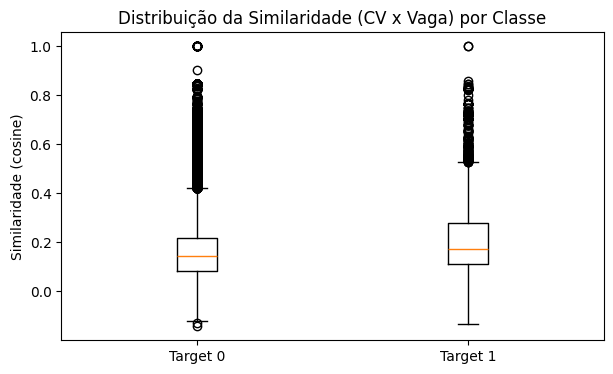

In [27]:
# Estatísticas básicas
grupo_0 = df[df['target'] == 0]['similaridade_cv_vaga']
grupo_1 = df[df['target'] == 1]['similaridade_cv_vaga']

print("Target=0 (não contratado): média =", grupo_0.mean(), " | std =", grupo_0.std(), " | n =", len(grupo_0))
print("Target=1 (contratado):      média =", grupo_1.mean(), " | std =", grupo_1.std(), " | n =", len(grupo_1))

# Teste t para diferença de médias
tstat, pval = ttest_ind(grupo_1, grupo_0, equal_var=False)
print(f"\nTeste t para diferença de médias: t={tstat:.3f}, p-valor={pval:.4f}")

# Gráfico boxplot
plt.figure(figsize=(7, 4))
plt.boxplot([grupo_0, grupo_1], tick_labels=['Target 0', 'Target 1'])
plt.title("Distribuição da Similaridade (CV x Vaga) por Classe")
plt.ylabel("Similaridade (cosine)")
plt.show()

Apesar do p-value mostrar diferença estatística (porque a amostra é grande), a diferença prática (média de 0.31 vs 0.30) é pequena e o boxplot mostra muita sobreposição das distribuições.

Similaridade entre CV e vaga não é um bom critério preditivo isolado de contratação e bem na verdade, para contratados tende a ser até um pouco menor

Isso pode refletir o contexto de TI e recrutamento, onde fatores não explícitos no texto (network, experiência específica, indicações, requisitos do cliente, etc) pesam mais do que “palavras em comum”.

## 5.  Pipeline

### 5.1 Seleção das features

Durante o desenvolvimento do modelo, foi necessário categorizar a similaridade entre o currículo (CV) e a vaga, pois do contrário identificamos que o CV em si poderia ter um peso muito alto em relação à todas as outras variáveis

**Principais pontos:**

* A similaridade entre CV e vaga é importante, mas não é o único critério relevante.
* O modelo precisa considerar múltiplas variáveis para aumentar sua capacidade preditiva.

In [28]:
df['similaridade_cv_vaga_bin'] = pd.cut(df['similaridade_cv_vaga'], bins=[0, 0.25, 0.5, 0.75, 1], labels=[0,1,2,3])

Seleção das features que temos interesse

In [30]:
features = [
    'cand_nivel_academico', 
    'cand_area_atuacao', 
    'cand_nivel_ingles', 
    'cand_nivel_espanhol',
    'cand_nivel_profissional',
    'vaga_nivel_academico_vaga', 
    'vaga_areas_atuacao_vaga', 
    'vaga_nivel_ingles_vaga',
    'vaga_nivel_espanhol_vaga',
    'vaga_nivel_profissional_vaga',
    'similaridade_cv_vaga_bin',
    'score_matching_skills'
]

X = df[features]
y = df['target']


### 5.2 Criando modelo

#### 5.2.1 Pré-processamento

In [31]:
X_enc = pd.get_dummies(X, drop_first=True)

#### 5.2.2 Split em treino e teste

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X_enc, y, test_size=0.2, stratify=y, random_state=42)

#### 5.2.3 Treino de RandomForesst

In [33]:
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced', 
    random_state=42,
    n_jobs=-1,
    
)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

#### 5.2.4 Avaliação do modelo

Após o treino da base, precisamos validar a precisão do nosso modelo em classifica candidatos:

* Aprovados (1) 
* Reprovados (0) 


Relatório de classificação:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92     10113
           1       0.19      0.47      0.27       639

    accuracy                           0.85     10752
   macro avg       0.58      0.67      0.59     10752
weighted avg       0.92      0.85      0.88     10752


AUC ROC: 0.7247746009993181

Matriz de confusão:
[[8832 1281]
 [ 337  302]]


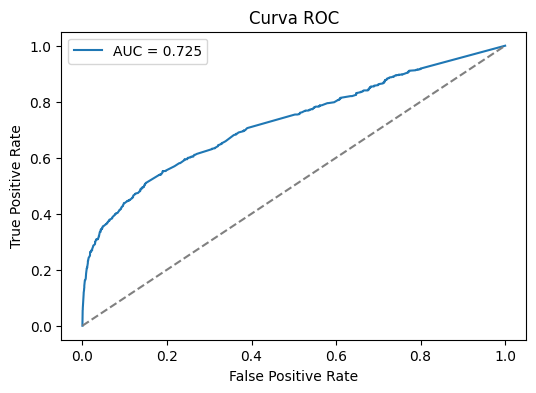

In [34]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("\nRelatório de classificação:")
print(classification_report(y_test, y_pred, digits=2))

print("\nAUC ROC:", roc_auc_score(y_test, y_proba))

print("\nMatriz de confusão:")
print(confusion_matrix(y_test, y_pred))

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_proba):.3f}')
plt.plot([0,1],[0,1],'--',color='grey')
plt.title('Curva ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

##### 5.2.5 Análise do resultado do Modelo

Conforme o resultado do modelo, verificamos:

- **Alta precisão para identificar candidatos reprovados (`0`)**:  
  - *Precision*: **0.96**
- **Baixa performance para classificar candidatos aprovados (`1`)**:  
  - *Precision*: **0.19**

O resultado **AUC ROC** foi **0.725**, considerado razoável, mas ainda há espaço para melhorias no modelo.

#### Relatório de Classificação

| Classe | Precision | Recall | F1-score | Suporte |
|--------|-----------|--------|----------|---------|
| **0** (Reprovado) | 0.96 | 0.87 | 0.92 | 10.113 |
| **1** (Aprovado)  | 0.19 | 0.47 | 0.27 |   639  |

**Acurácia geral:** **0.85** (10.752 amostras)

**Observação:** Temos scores de Acurácia e AUC Roc relatavimente elevados, em consequencia da precisão na classificação de candidatos reprovados, o que neste caso não faz correlação direta com eficiencia geral do modelo.

---

### 5.3 Análise de Features

Para entendermos a "importancia" de cada feature, vamos analisar o schore que o modelo clf atribuiu para cada feature.

#### 5.3.1 Lista de features


Importância das features (top 10):
score_matching_skills                      0.112374
vaga_nivel_ingles_vaga_Nenhum              0.080413
vaga_areas_atuacao_vaga_TI - Projetos-     0.060908
vaga_areas_atuacao_vaga_Administrativa-    0.047640
vaga_nivel_profissional_vaga_Sênior        0.040329
similaridade_cv_vaga_bin_1                 0.040238
vaga_nivel_espanhol_vaga_Nenhum            0.036224
vaga_nivel_espanhol_vaga_Básico            0.034262
vaga_nivel_profissional_vaga_Pleno         0.030084
vaga_nivel_ingles_vaga_Básico              0.029105
dtype: float64


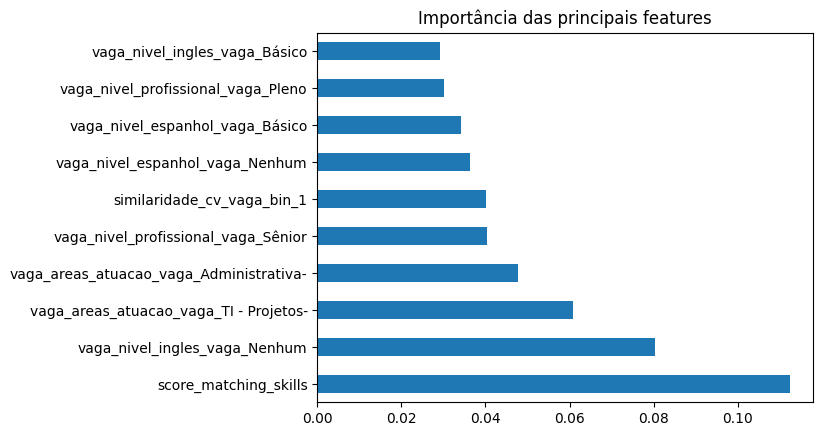

In [35]:
importances = pd.Series(clf.feature_importances_, index=X_enc.columns).sort_values(ascending=False)
print("\nImportância das features (top 10):")
print(importances.head(10))
importances.head(10).plot(kind='barh', title='Importância das principais features')
plt.show()

##### 5.3.2 Análise de score de features

Como mostra o gráfico acima, identificamos que o modelo atribui um peso maior às features relacionadas ao score_matching_skills, o que faz sentido, já que as vagas possuem pré-requisitos técnicos específicos.

O modelo pondera de forma lógica sobre as features técnicas.
Portanto, a oportunidade de ajuste está mais relacionada à escolha da métrica de avaliação do que ao peso das features em si.

### 5.4 Ajuste de threshold do modelo

O critério padrão do modelo para categorização de candidatos aprovados não demonstrou precisão satisfatória para a base analisada.

Após testarmos o modelo, verificamos que ao aumentar o threshold de análise para 0.83, houve um ganho considerável na precisão da aprovação de candidatos

Melhor threshold para maior F1: 0.83
Precision: 0.479, Recall: 0.263, F1: 0.339


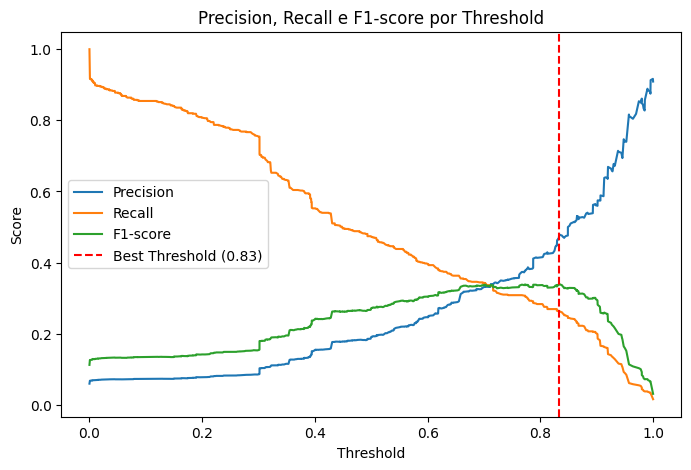


Relatório com threshold customizado:
              precision    recall  f1-score   support

           0      0.955     0.982     0.968     10113
           1      0.479     0.263     0.339       639

    accuracy                          0.939     10752
   macro avg      0.717     0.622     0.654     10752
weighted avg      0.926     0.939     0.931     10752

[[9930  183]
 [ 471  168]]


In [36]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f'Melhor threshold para maior F1: {best_threshold:.2f}')
print(f'Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}, F1: {f1s[best_idx]:.3f}')

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], label='Precision')
plt.plot(thresholds, recalls[:-1], label='Recall')
plt.plot(thresholds, f1s[:-1], label='F1-score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1-score por Threshold')
plt.legend()
plt.show()

y_pred_custom = (y_proba >= best_threshold).astype(int)
print("\nRelatório com threshold customizado:")
print(classification_report(y_test, y_pred_custom, digits=3))
print(confusion_matrix(y_test, y_pred_custom))

A precisão para a classe **"Aprovado" (1)** subiu de **0.19 (19%)** para **0.48 (48%)**, uma grande melhoria.  
Além disso, a métrica de **"alarmes falsos" (Falsos Positivos)** caiu de **1278** para apenas **183**.

**Melhor threshold para maior F1:** `0.83`  
**Precision:** `0.479`  
**Recall:** `0.263`  
**F1:** `0.339`

#### Relatório com threshold customizado

| Classe | Precision | Recall | F1-score | Suporte |
|--------|-----------|--------|----------|---------|
| **0**  | 0.955     | 0.982  | 0.968    | 10113   |
| **1**  | 0.479     | 0.263  | 0.339    | 639     |

**Acurácia geral:** `0.939` (10.752 amostras)  
**Macro avg:** Precision `0.717` | Recall `0.622` | F1-score `0.654`  
**Weighted avg:** Precision `0.926` | Recall `0.939` | F1-score `0.931`


### 5.5 Ajustando para o threshold identificado como ideal

In [37]:
# usa o primeiro se quiser o original, se não o clf.predict_proba
#y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
threshold = best_threshold

y_pred = (y_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred, digits=3))
print("Matriz do confuso:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0      0.955     0.982     0.968     10113
           1      0.479     0.263     0.339       639

    accuracy                          0.939     10752
   macro avg      0.717     0.622     0.654     10752
weighted avg      0.926     0.939     0.931     10752

Matriz do confuso:
[[9930  183]
 [ 471  168]]


Utilizamos ajuste de threshold para maximizar o F1-score, obtendo um equilíbrio prático entre precision e recall para a predição de contratações. O threshold ótimo permitiu identificar contratados com uma precisão boa, mesmo em um cenário de forte desbalanceamento, mostrando que o modelo pode ser ajustado conforme a estratégia do negócio — seja priorizando recall (acertar mais contratados) ou precision (evitar falsos positivos).

## 6. Exportar o modelo

In [38]:
if MODO_LOCAL:
    joblib.dump(clf, 'modelo_rf.pkl')
    X_train_enc = pd.get_dummies(X_train)
    with open('features.pkl', 'wb') as f:
        pickle.dump(list(X_train_enc.columns), f)
    importances = clf.feature_importances_
    with open('importances.pkl', 'wb') as f:
        pickle.dump(importances, f)

else:
    joblib.dump(clf, 'modelo_rf_light.pkl')
    X_train_enc = pd.get_dummies(X_train)
    with open('features_light.pkl', 'wb') as f:
        pickle.dump(list(X_train_enc.columns), f)
    importances = clf.feature_importances_
    with open('importances_light.pkl', 'wb') as f:
        pickle.dump(importances, f)

In [39]:
threshold_otimo = best_threshold
with open('threshold.txt', 'w') as f:
    f.write(str(threshold_otimo))